## AI初探-自己打造神經網路模型
在這個課程裡，我們會介紹如果運用keras介面搭配tensorflow框架打造一個神經網路模型來訓練電腦辨認物體. 這邊我們採用[Cifar-10](https://www.cs.toronto.edu/~kriz/cifar.html)資料集作為範例. Cifar-10 是由深度學習大師 Geoffrey Hinton 教授與其在加拿大多倫多大學的學生 Alex Krixhevsky 與 Vinoid Nair 整理的影像資料集, 包含 6 萬筆 32x32 低解析度彩色圖片, 其中 5 萬筆為訓練集, 1 萬筆為測試集, 是機器學習中常用的圖片辨識資料集  

備註:本課程之內容由余執彰老師編輯, 僅限中原大學教學使用

In [1]:
import numpy as np
import random
import PIL
import matplotlib.pyplot as plt

Cifar-10資料集的大小約為170mb, 我們可以透過keras提供的方法來載入這個資料集,使用方法為  
```python
from tensorflow.keras.datasets import cifar10
```
匯入完畢後我們就可以使用`cifar10.load_data()`來載入資料集。第一次使用的時候必須先從網路上下載這個資料集，因此會先花掉一點時間。

In [2]:
from tensorflow.keras.datasets import cifar10

下載下來的資料會被存放在下面的位置, 同學們可以自行到該資料夾位置查看實際的檔案    
(windows)`C:\Users\MY_USER_NAME\.keras\datasets`  
(ubuntu)`~/.keras/datasets/cifar-10-batches-py`  
載入的資料會自動被分成訓練資料與測試資料, 訓練資料用來訓練模型, 測試資料用來評估模型的好壞.  
兩種資料分別有影像資料跟對應的標記. 我們可以使用下面的語法將他們區分開來:

In [3]:
(X_train, y_train),(X_test, y_test) = cifar10.load_data()

我們來看一下資料的組成. **X_train** 的組成結構為 (影像編號, 寬, 高, 通道數), **y_train** 的組成結構為 (影像編號,1).  
**X_train** 的結構表示說有50000張的訓練影像, 影像尺寸為32x32, 3表示是由 r,g,b 三原色組成的彩色影像.  
**y_train** 的內容則是這50000張影像的對應類別編號, 記錄了每張影像屬於哪個類別. cifar10資料集內有10種不同的物體, 因此 **y_train** 的內容會是介於 0-9 的數字.

In [6]:
print('X_train:' + str(X_train.shape))
print('y_train:' + str(y_train.shape))

X_train:(50000, 32, 32, 3)
y_train:(50000, 1)


我們隨機的挑出一張圖片來看一下他的內容. python有一個套件matplotlib可以協助我們做到這件事情.使用方式也很簡單,只要輸入下列指令就可匯入此套件：  
```python 
import matplotlib.pyplot as plt
```  
接著隨意挑出一張圖片的資料並使用 
```python 
plt.imshow()
```
指令來顯示圖片. 你可以嘗試多執行幾次下面的程式片段來檢查不同的圖片內容.

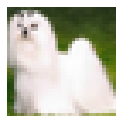

the label is 5


In [8]:
idx = random.randint(0, 49999)
im = X_train[idx]
plt.figure(figsize=(2,2))
plt.axis('off')
plt.imshow(im)
plt.show()
print('the label is '+ str(y_train[idx][0]))

下面是每個數字對應的類別名稱：

|編號|0|1|2|3|4|5|6|7|8|9
|---|---|---|---|---|---|---|---|---|---|---|
|名稱|airplane|automobile|bird|cat|deer|dog|frog|horse|ship|truck

為了把資料的類別表示得更清楚, 我們可以建立一個表來查詢每個數字究竟是對應到哪一種物體.

In [15]:
label_name=['airplaine', 'automobile', 'bird', 'cat', 'deer', 
            'dog', 'frog', 'horse', 'ship', 'truck']

接著我們可以隨機的挑出幾張圖片並標記出對應的類別名稱.你一樣可以嘗試多執行幾次下面的程式片段來檢查不同的圖片內容.

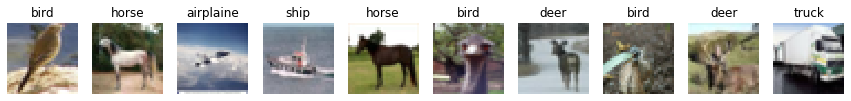

In [17]:
fig, ax = plt.subplots(1, 10, figsize=(15,5))
for i in range(10):
    idx = random.randint(0, 49999)
    im = X_train[idx]
    label = y_train[idx][0]
    ax[i].imshow(im)
    ax[i].set_title(label_name[label])
    ax[i].axis('off')

把資料交由模型訓練前, 我們必須把資料正規化. 這邊正規化的意思是, 原本數位影像儲存的資訊是0-255, 我們要把他正規化到0-1之間, 這樣模型才能學得比較穩定.

In [50]:
X_train = X_train/np.max(X_train)
X_test = X_test/np.max(X_test)

再來我們要處理負責儲存物體類別標記的資料 y_train 跟 y_test. 原本標記的資料內容是介於 0-9 的數字, 但這個數字的不同對於分類問題來說是沒有意義的, 因為cat被分成第三類, 鳥分成第二類的原因並不是因為數字3比數字2來的大, 僅僅是因為他們代表不同的東西而已. 因此, 我們得先把數字 0-9 轉換成*10個類別*. 這件事可以利用**one-hot encoding**技術做到. 所謂的 one-hot encoding 就是把資料用一個二元的向量來表示, 每一個數字在轉換的二元向量中只會擁有一個 1,其他都是 0. 舉例來說, 如果想要區分紅, 黃, 綠三種顏色, 我們可以定義每種顏色分別為 [1, 0, 0], [0, 1, 0] 和 [0, 0, 1].  

在keras中, 我們可以利用`to_categorical()`這個函式來做到這個轉換:

In [20]:
from tensorflow.keras.utils import to_categorical
y_categorical = to_categorical(y_train)

執行下面的程式片段, 你可以看到轉換的結果.

In [22]:
idx = random.randint(1,49999)
print('original label is: '+str(y_train[idx]))
print('corresponding one-hot encoding:'+ str(y_categorical[idx]))

original label is: [8]
corresponding one-hot encoding:[0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]


接下來我們要開始來建立學習的模型. 這邊使用的是keras搭配tensorflow框架建立模型. Keras是一個介面，而非獨立的機器學習框架. 目的是提供更直觀的方式讓用戶可以輕鬆地開發深度學習模型.你可以在[keras官方網站](https://keras.io/)或是[keras中文網站(簡體中文)](https://keras.io/zh/)得到更多訊息. 首先我們匯入keras的相關函式庫:

In [34]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, MaxPool2D, Conv2D, Flatten, BatchNormalization, Dropout
from tensorflow.keras.optimizers import RMSprop

接著我們利用keras的順序模型(Sequential)來打造一個神經網路.順序模型是把每一層的網路疊加起來, 可以簡單的使用 `.add()` 指令來加入神經網路的每一層. 舉例來說,如果我們想要完成一個這樣的神經網路模型, 我們需要使用3次 `.add()`, 一次加入一層  
<img src="mlp.png" width="600">

In [41]:
mlp_model = Sequential()

mlp_model.add(Flatten(input_shape=(32,32,3), name = 'input'))
mlp_model.add(Dense(512, activation = 'tanh', name = 'hidden1'))
mlp_model.add(Dense(10, activation = 'sigmoid', name = 'output'))

因為輸入的影像資料是3維資料(長x寬x色深), 但這個神經網路只接受一維平面的輸入, 因此我們先用`Flatten()`這個指令把影像轉成一維的資料.  `Dense()`指的是神經網路中的全連接層. 第一個數字表示網路的神經元個數, 這個數字越大表示這一層的神經元的數量越多(但代價是龐大的計算量).因此在第二層(隱藏層)我們設計為是一個有512個神經元的層. 最後的輸出層則是根據想要分類的類別數量來決定.以Cifar-10來說，輸出層的神經元個數就設定成10, 表示要分辨10種不同的物體.  

註：其他的參數例如 activation 稱為激勵函數或是活化函數, 目的是讓網路能具備擬合非線性問題的能力. 可參考維基百科對 [激勵函數](https://zh.wikipedia.org/wiki/%E6%BF%80%E6%B4%BB%E5%87%BD%E6%95%B0) 的說明

接著我們使用`.summary()`方法來確認模型有沒有符合我們的心裡所想的設計:

In [39]:
mlp_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (Flatten)              (None, 3072)              0         
_________________________________________________________________
hidden1 (Dense)              (None, 512)               1573376   
_________________________________________________________________
output (Dense)               (None, 10)                5130      
Total params: 1,578,506
Trainable params: 1,578,506
Non-trainable params: 0
_________________________________________________________________


在開始訓練之前, 我們要先把資料集打散並區分成訓練樣本(training data)與驗證樣本(validation data). 也就是說,我們利用訓練樣本來訓練模型參數,用驗證樣本來驗證這個模型的參數是否夠泛用(generalization), 這樣可以讓我們觀察模型是否有發生過擬合(overfitting)的問題.執行以下的程式區塊可以把X_train 跟 y_categorical(one-hot encoding 後的 y_train)再切割成兩部分. 其中的test_size參數可以自行調整, 0.2表示有20%的資料會被切成驗證樣本.

In [24]:
from sklearn.model_selection import train_test_split
trainX, validX, trainY, validY = train_test_split(X_train, y_categorical, test_size=0.2, random_state=42)
print('training data has '+ str(len(trainX)) + ' samples.')
print('testing data has '+ str(len(validX)) + ' samples.')

training data has 40000 samples.
testing data has 10000 samples.


我們可以開始訓練模型了！使用`fit()`方法, 把我們準備好的資料餵進去. 因為神經網路的訓練是一個迭代式(iterative)的學習, epochs 參數是用來設定我們的模型要重複學習幾次. 這個數字沒有一定的標準, 視資料的複雜程度而定. 但一般而言, 學習次數過少, 模型容易欠擬合(underfitting), 表示還沒學習到正確的資訊; 學習次數過多, 模型則容易過擬合(overfitting), 無法正確處理從未看過的輸入.

註：這邊的 loss 稱為損失函數, 是用來計算模型推估的結果跟實際結果之間的誤差, optimizer叫做優化器, 是學習過程中所採用的更新權重參數的策略. 有興趣的同學可以參考以下連結：  
- [損失函數](https://keras.io/zh/losses/)
- [優化器](https://keras.io/zh/optimizers/)

In [42]:
mlp_model.compile(loss='categorical_crossentropy', 
                  optimizer=RMSprop(lr=0.0001, decay=1e-6), 
                  metrics=['accuracy'])
history = mlp_model.fit(trainX, trainY, epochs=20, validation_data=(validX, validY))

Train on 40000 samples, validate on 10000 samples
Epoch 1/20
40000/40000 [==============================] - 5s 133us/sample - loss: 1.8947 - acc: 0.3182 - val_loss: 1.7606 - val_acc: 0.3722
Epoch 2/20
40000/40000 [==============================] - 6s 152us/sample - loss: 1.7048 - acc: 0.3955 - val_loss: 1.6449 - val_acc: 0.4136
Epoch 3/20
40000/40000 [==============================] - 5s 132us/sample - loss: 1.6268 - acc: 0.4242 - val_loss: 1.6615 - val_acc: 0.4191
Epoch 4/20
40000/40000 [==============================] - 5s 130us/sample - loss: 1.5733 - acc: 0.4443 - val_loss: 1.5860 - val_acc: 0.4283
Epoch 5/20
40000/40000 [==============================] - 7s 164us/sample - loss: 1.5306 - acc: 0.4608 - val_loss: 1.5595 - val_acc: 0.4408
Epoch 6/20
40000/40000 [==============================] - 7s 176us/sample - loss: 1.4957 - acc: 0.4710 - val_loss: 1.5271 - val_acc: 0.4615
Epoch 7/20
40000/40000 [==============================] - 7s 181us/sample - loss: 1.4634 - acc: 0.4845 - val_l

學習完畢後, 我們可以把學習的過程畫出來觀察. 我們可以發現到, 這個模型的學習結果並不是太好, 經過了20次的迭代後大約只有50~60%左右的正確率.且驗證樣本的準確率已經趨緩, 表示模型已經差不多學到了極限.

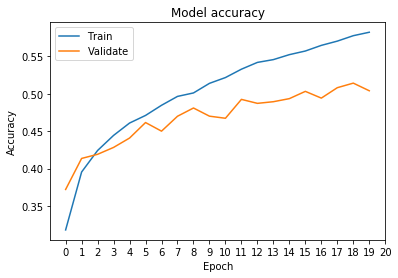

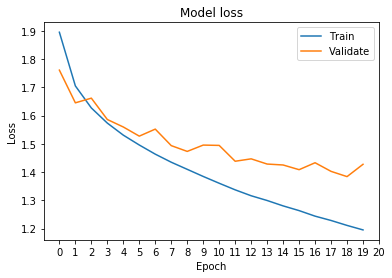

In [44]:
# Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.xticks(np.arange(0, 21, 1))
plt.legend(['Train', 'Validate'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.xticks(np.arange(0, 21, 1))
plt.legend(['Train', 'Validate'], loc='best')
plt.show()

接著我們來用看看另一個常見的模型 - 卷積神經網路 (Convolution Neural Network, CNN). CNN包含了一個基本的循序操作: 卷積->池化->全連接
- 卷積(convolution): 使用一些濾波器(filter)來找出影像中的特徵
- 池化(pooling): 用來壓縮圖片同時保留影像的重要資訊
- 全連接(fully connection): 同傳統的類神經網路一樣, 用來做最後的分類

其中卷積跟池化是可以持續疊加的, 因此我們可以一直重複 卷積->池化 的動作來減少模型的參數，最後加上全連接層來分類. 如同下面的範例, 我們採用了一個兩次的卷積跟一個全連接層的設計:

In [47]:
cnn_model = Sequential()
cnn_model.add(Conv2D(32, (3, 3), padding='same', input_shape=(32, 32, 3), activation='relu'))
cnn_model.add(MaxPool2D(pool_size=(2, 2)))

cnn_model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
cnn_model.add(MaxPool2D(pool_size=(2, 2)))

cnn_model.add(Flatten())
cnn_model.add(Dense(512, activation='relu'))
cnn_model.add(Dense(10, activation='softmax'))

把模型結構印出來看, 可以發現大約有200萬個左右的參數需要訓練.

In [31]:
cnn_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 4096)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               2097664   
_________________________________________________________________
dense_1 (Dense)              (None, 10)                5130      
Total para

In [48]:
cnn_model.compile(loss='categorical_crossentropy',
                  optimizer= RMSprop(lr=0.0001, decay=1e-6),
                  metrics=['accuracy'])
history = cnn_model.fit(trainX, trainY, epochs=20, validation_data=(validX, validY))

Train on 40000 samples, validate on 10000 samples
Epoch 1/20
40000/40000 [==============================] - 11s 277us/sample - loss: 1.6436 - acc: 0.4166 - val_loss: 1.4095 - val_acc: 0.4940
Epoch 2/20
40000/40000 [==============================] - 12s 311us/sample - loss: 1.3366 - acc: 0.5254 - val_loss: 1.2603 - val_acc: 0.5541
Epoch 3/20
40000/40000 [==============================] - 13s 322us/sample - loss: 1.2136 - acc: 0.5755 - val_loss: 1.1694 - val_acc: 0.5885
Epoch 4/20
40000/40000 [==============================] - 11s 272us/sample - loss: 1.1268 - acc: 0.6061 - val_loss: 1.1009 - val_acc: 0.6201
Epoch 5/20
40000/40000 [==============================] - 11s 269us/sample - loss: 1.0515 - acc: 0.6372 - val_loss: 1.0542 - val_acc: 0.6357
Epoch 6/20
40000/40000 [==============================] - 12s 307us/sample - loss: 0.9954 - acc: 0.6557 - val_loss: 1.0096 - val_acc: 0.6464
Epoch 7/20
40000/40000 [==============================] - 11s 285us/sample - loss: 0.9461 - acc: 0.6704 

我們也一樣畫出模型的學習過程. 可以發現到, 模型對驗證樣本的正確率提升到了 70% 左右.

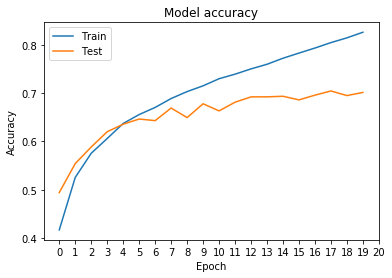

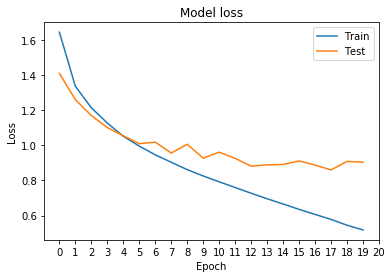

In [49]:
# Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.xticks(np.arange(0, 21, 1))
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.xticks(np.arange(0, 21, 1))
plt.legend(['Train', 'Test'], loc='best')
plt.show()

我們從測試資料集 **X_test** 隨機的取出一張圖片來測試訓練出來的模型, 看看預測的情況怎麼樣. 同學可以重複執行下面的程式區塊幾次, 看看模型對每個不同的物體的辨認結果.

Text(0.5, 1.0, '50.95% cat')

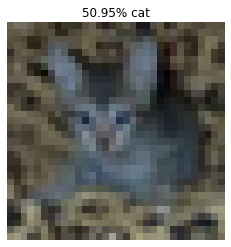

In [70]:
idx = random.randint(0,9999)
im = X_test[idx]
prediction = cnn_model.predict(im.reshape(1,32,32,3))
predicted_label = np.argmax(prediction)
plt.imshow(im)
plt.axis('off')
text = '{:.2f}% {}'.format(prediction[0][predicted_label]*100, label_name[predicted_label])
plt.title(text)

我們也可以把所有的測試樣本全部餵給模型,得到一個統整性的辨認結果.

In [66]:
y_pred = cnn_model.predict(X_test)

最後我們利用了 `sklearn.metrics.classification_report` 這個功能來顯示模型的整體預測結果. 這些衡量模型好壞的評估方式為
- precision: 正確的物件佔被模型判斷成該物件的比例
- recall: 正確的物件佔所有該物件的比例
- f1-score: precision 和 recall 的調和平均數

In [72]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred.argmax(axis=1), target_names=label_name))

              precision    recall  f1-score   support

   airplaine       0.74      0.75      0.75      1000
  automobile       0.88      0.71      0.79      1000
        bird       0.70      0.50      0.58      1000
         cat       0.50      0.56      0.53      1000
        deer       0.68      0.63      0.65      1000
         dog       0.59      0.63      0.61      1000
        frog       0.87      0.69      0.77      1000
       horse       0.66      0.84      0.74      1000
        ship       0.77      0.85      0.81      1000
       truck       0.71      0.83      0.76      1000

    accuracy                           0.70     10000
   macro avg       0.71      0.70      0.70     10000
weighted avg       0.71      0.70      0.70     10000

